In [8]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>")) # makes the notebook fill the whole window

import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import matplotlib as mpl
from matplotlib import pyplot as plt
import matplotlib.patches as patches
import datetime
import os
import re
import pandas as pd
import shutil
import pycubicspline
import BetterMap

from sklearn.preprocessing import MinMaxScaler

from mpl_toolkits.basemap import Basemap

import matplotlib.image as mpimg

from glmtools.io.glm import GLMDataset

import haversine

from squeemtools.Graphing import MakeBigGraph
import BetterMap as BM

import storm_centered_coords as scc

import warnings
warnings.filterwarnings("ignore")

In [69]:
directory = './NCPython/NCPython/242/00/'
filename = 'OR_GLM-L2-LCFA_G16_s20182420000000_e20182420000200_c20182420000224.nc'
area = (-62,-52,-26,-36)
glm = GLMDataset(directory + filename)
#MakeBigGraph(glm.dataset,5,(-60,-45,-14.5,-30))
glm.dataset

<xarray.Dataset>
Dimensions:                                 (number_of_events: 36123, number_of_field_of_view_bounds: 2, number_of_flashes: 789, number_of_groups: 13933, number_of_time_bounds: 2, number_of_wavelength_bounds: 2)
Coordinates:
    event_id                                (number_of_events) uint32 2132056...
    event_time_offset                       (number_of_events) datetime64[ns] ...
    event_lat                               (number_of_events) float32 -0.681...
    event_lon                               (number_of_events) float32 -69.97...
    event_parent_group_id                   (number_of_events) uint32 9043873...
    group_id                                (number_of_groups) uint32 9043873...
    group_time_offset                       (number_of_groups) datetime64[ns] ...
    group_lat                               (number_of_groups) float32 -0.681...
    group_lon                               (number_of_groups) float32 -69.97...
    group_parent_flash_id                   (number_of_groups) uint16 26069 ....
    flash_id                                (number_of_flashes) uint16 26069 ...
    flash_time_offset_of_first_event        (number_of_flashes) datetime64[ns] ...
    flash_time_offset_of_last_event         (number_of_flashes) datetime64[ns] ...
    flash_lat                               (number_of_flashes) float32 -0.69...
    flash_lon                               (number_of_flashes) float32 -69.9...
    product_time                            datetime64[ns] 2018-08-30
    lightning_wavelength                    float32 ...
    group_time_threshold                    float32 ...
    flash_time_threshold                    float32 ...
    lat_field_of_view                       float32 ...
    lon_field_of_view                       float32 -75.0
Dimensions without coordinates: number_of_events, number_of_field_of_view_bounds, number_of_flashes, number_of_groups, number_of_time_bounds, number_of_wavelength_bounds
Data variables:
    event_energy                            (number_of_events) float32 1.5259...
    group_area                              (number_of_groups) float32 64.612...
    group_energy                            (number_of_groups) float32 1.5259...
    group_quality_flag                      (number_of_groups) float32 ...
    flash_area                              (number_of_flashes) float32 258.5...
    flash_energy                            (number_of_flashes) float32 5.646...
    flash_quality_flag                      (number_of_flashes) float32 ...
    product_time_bounds                     (number_of_time_bounds) datetime64[ns] ...
    lightning_wavelength_bounds             (number_of_wavelength_bounds) float32 ...
    lat_field_of_view_bounds                (number_of_field_of_view_bounds) float32 ...
    goes_lat_lon_projection                 int32 ...
    event_count                             float64 ...
    group_count                             float64 ...
    flash_count                             float64 ...
    percent_navigated_L1b_events            float32 ...
    yaw_flip_flag                           float32 ...
    nominal_satellite_subpoint_lat          float32 ...
    nominal_satellite_height                float32 ...
    nominal_satellite_subpoint_lon          float32 ...
    lon_field_of_view_bounds                (number_of_field_of_view_bounds) float32 ...
    percent_uncorrectable_L0_errors         float32 ...
    algorithm_dynamic_input_data_container  int32 ...
    processing_parm_version_container       int32 ...
    algorithm_product_version_container     int32 ...
    event_parent_flash_id                   (number_of_events) uint16 26069 ....
    flash_child_group_count                 (number_of_flashes) int32 8 34 ... 6
    group_child_event_count                 (number_of_groups) int32 1 2 ... 1 1
    flash_child_event_count                 (number_of_flashes) int32 17 ... 7
    event_x                                 (numbe

In [15]:
%%time
FolderToCSV('./NCPython/NCPython/242/00/')

Wall time: 22min 48s


'2018-08-30T00-00-00-000000000.csv'

In [8]:
%time grps = pd.read_csv('./Data/08_31_2018_-55.5_-47.5_26.0_-30.0_groups.csv')
%time grps['group_time_offset'] = grps['group_time_offset'].apply(pd.to_datetime)
%time grps['group_energy'] = pd.to_numeric(grps['group_energy'], errors='coerce')

%time evnts = pd.read_csv('./Data/08_31_2018_-55.5_-47.5_26.0_-30.0_events.csv')
%time evnts['event_time_offset'] = evnts['event_time_offset'].apply(pd.to_datetime)
%time evnts['event_energy'] = pd.to_numeric(evnts['event_energy'], errors='coerce')

%time flshs = pd.read_csv('./Data/08_31_2018_-55.5_-47.5_26.0_-30.0_flashes.csv')
%time flshs['flash_time_offset_of_first_event'] = flshs['flash_time_offset_of_first_event'].apply(pd.to_datetime)
%time flshs['flash_energy'] = pd.to_numeric(flshs['flash_energy'], errors='coerce')

Wall time: 1.89 s
Wall time: 3min 48s
Wall time: 5.98 ms
Wall time: 3.35 s
Wall time: 8min 48s
Wall time: 15 ms
Wall time: 123 ms
Wall time: 12.3 s
Wall time: 0 ns


In [40]:
%%time
lndir = './WWLLN Oct 2018/'
lnfile = 'AE20180831.loc'
df = pd.read_csv(lndir + lnfile,header=None,names=["Date","Time","Latitude","Longitude","Error","NumberStations","Energy",'Energy_std',"NumStationsEnergy"],low_memory=False)
df['dt'] = (df['Date'] + '-' + df['Time']).apply(pd.to_datetime,format="%Y/%m/%d-%H:%M:%S.%f")
df = df.drop(columns=['Date','Time'])

Wall time: 1min 48s


In [66]:
%%time
area = (-55.5,-47.5,26,-30)

# Get locations from the WWLLN data, create a dataframe of just the energies
#localize = df[(df['Longitude'] >= area[0]) & (df['Longitude'] <= area[1]) & (df['Latitude'] >= area[3]) & (df['Latitude'] <= area[2])] # Is this the problem?
localize = df.copy()
enDf = localize[localize['NumStationsEnergy'] >= 2][['dt','Energy']]
enDf = enDf[(enDf['Energy'] >= 2) & (enDf['Energy'] < 10e7)]

# Scale all of the data down
scale = MinMaxScaler((0,1))
enDf['Energy'] = scale.fit_transform(enDf['Energy'].values.reshape(-1,1))
enDf.sort_values(by='dt',inplace=True)
scale2 = MinMaxScaler((0,1))
grps['group_energy'] = scale2.fit_transform(grps['group_energy'].values.reshape(-1,1))
grps.sort_values(by='group_time_offset',inplace=True)
scale3 = MinMaxScaler((0,1))
evnts['event_energy'] = scale3.fit_transform(evnts['event_energy'].values.reshape(-1,1))
evnts.sort_values(by='event_time_offset',inplace=True)
scale4 = MinMaxScaler((0,1))
flshs['event_energy'] = scale4.fit_transform(flshs['flash_energy'].values.reshape(-1,1))
flshs.sort_values(by='flash_time_offset_of_first_event',inplace=True)

Wall time: 587 ms


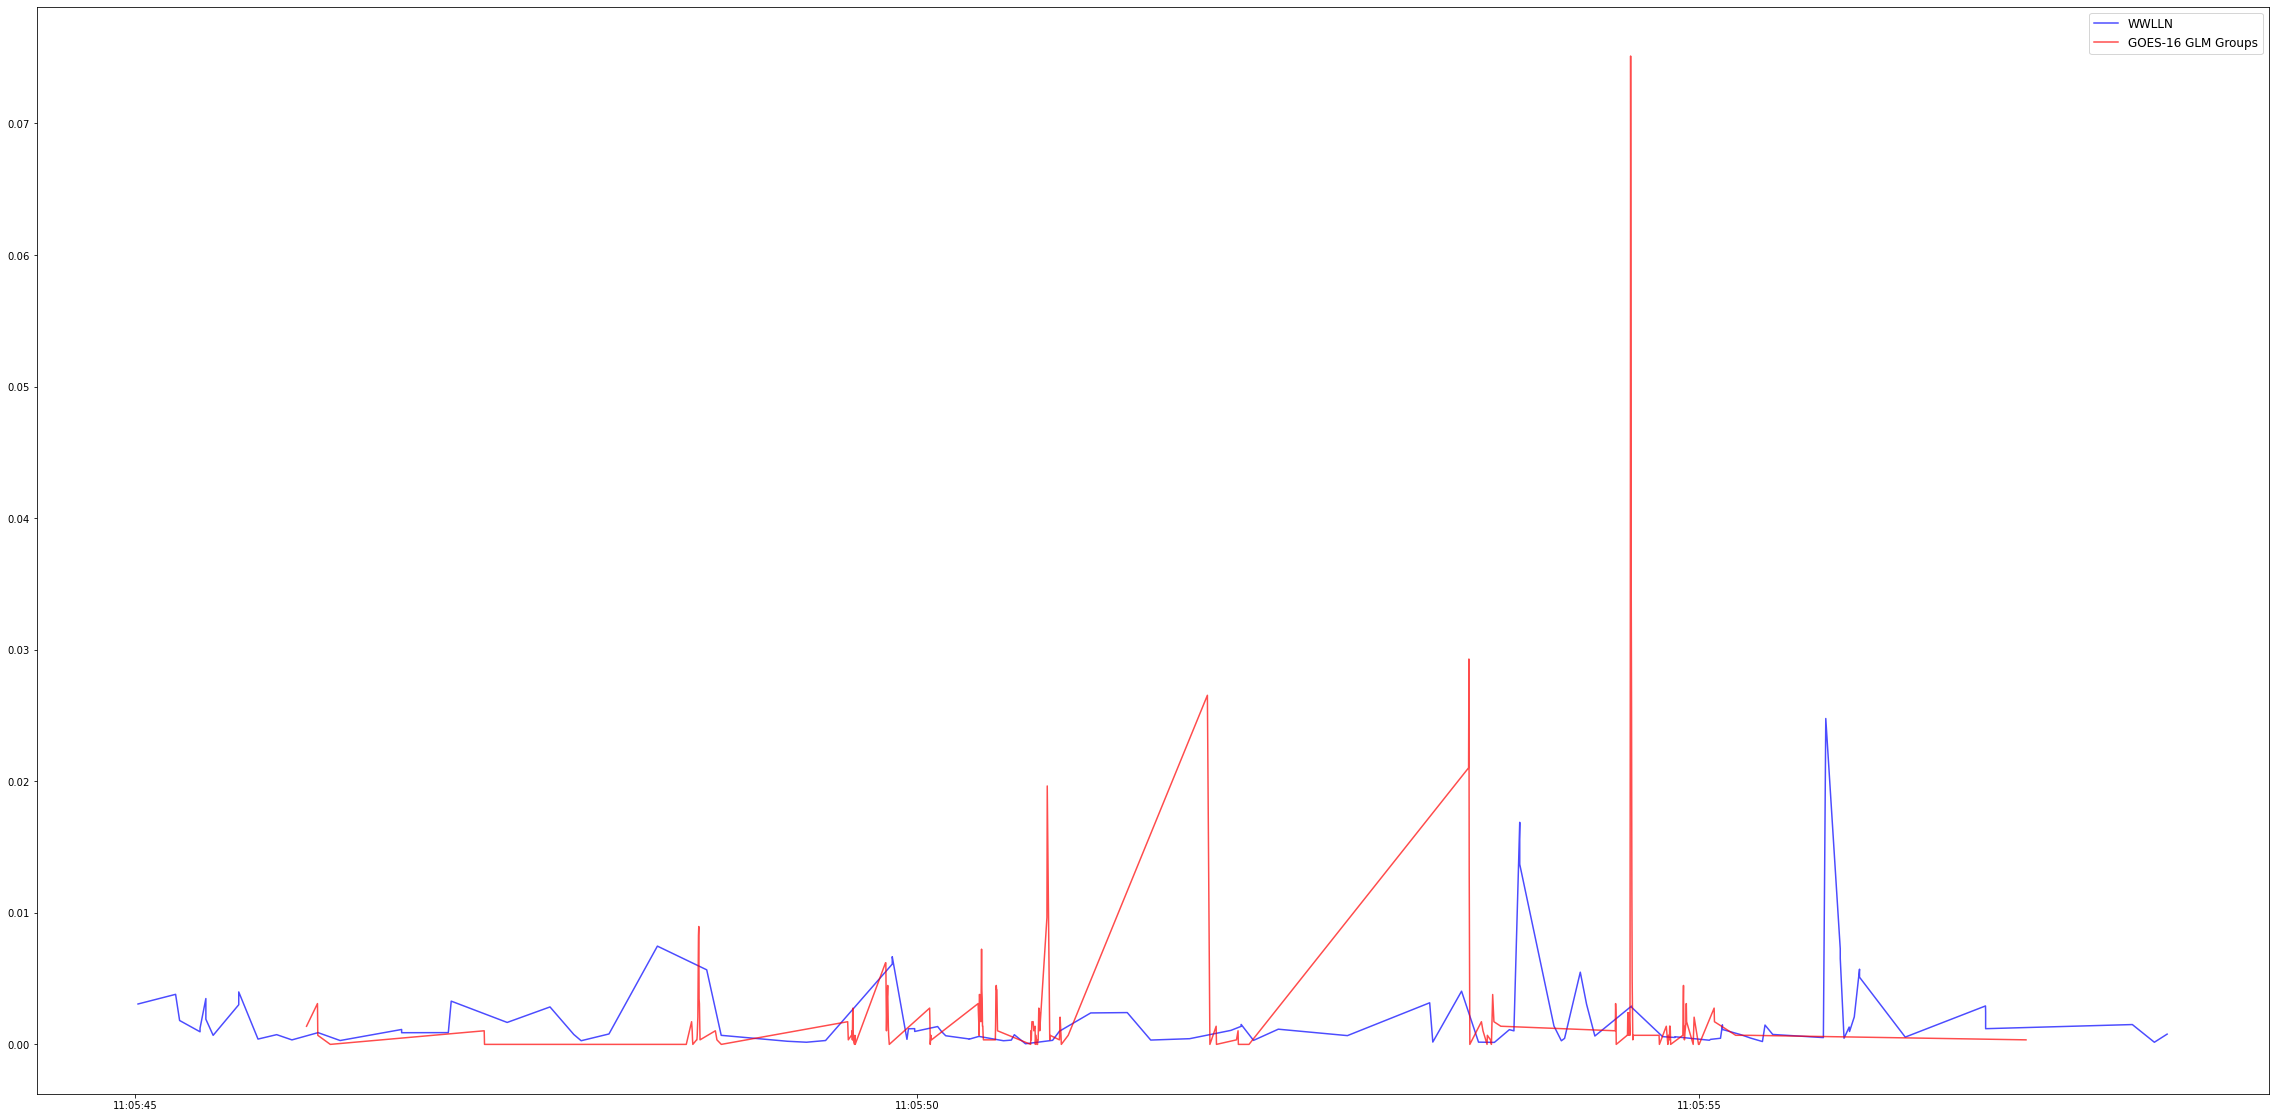

In [67]:
# Interesting times to look at WWLLN and GLM data

# Compare with Jun, doesn't mimic the same thing??
# Doesn't even show the same megaflash event in the WWLLN dataset, maybe the location is wrong?
start = pd.to_datetime('2018-08-31 11:05:45')
end = pd.to_datetime('2018-08-31 11:05:58')

loc1 = enDf[(enDf['dt'] > start) & (enDf['dt'] < end)]
loc2 = grps[(grps['group_time_offset'] > start) & (grps['group_time_offset'] < end)]

plt.figure(figsize=(40,20))
plt.plot(loc1['dt'],loc1['Energy'],c='blue',alpha=.7,label='WWLLN')
plt.plot(loc2['group_time_offset'],loc2['group_energy'],c='red',alpha=.7,label='GOES-16 GLM Groups')
plt.legend(fontsize=12)
plt.show()

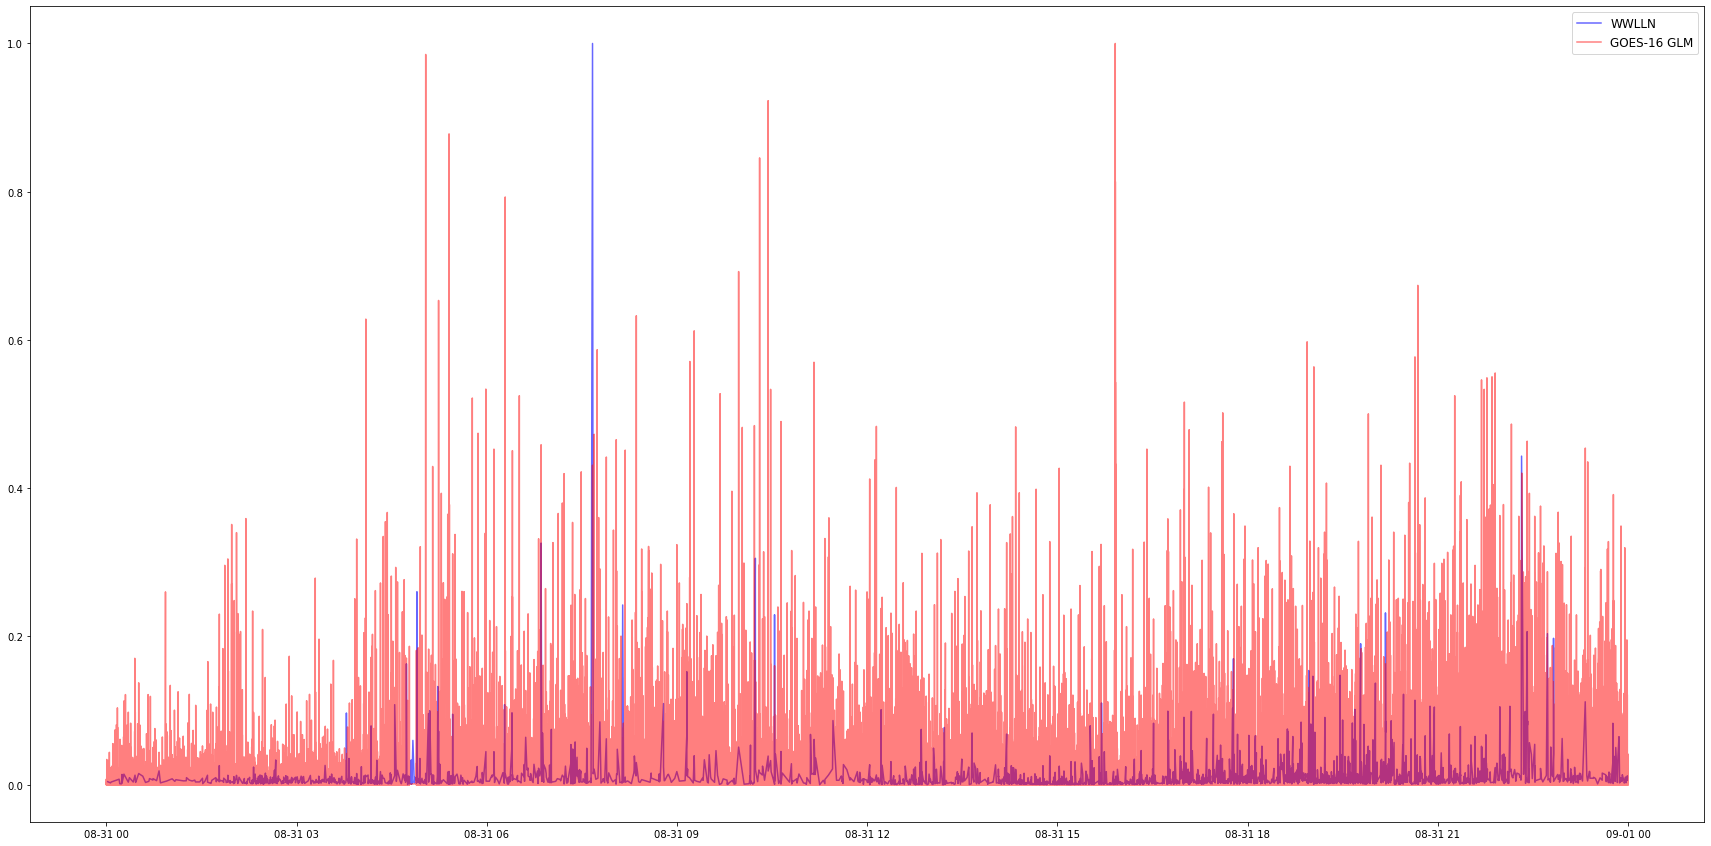

In [63]:
plt.figure(figsize=(30,15))
plt.plot(enDf['dt'],enDf['Energy'],c='blue',alpha=.6,label='WWLLN')
plt.plot(grps['group_time_offset'],grps['group_energy'],c='red',alpha=.5,label='GOES-16 GLM')
plt.legend(fontsize=12)
plt.show()

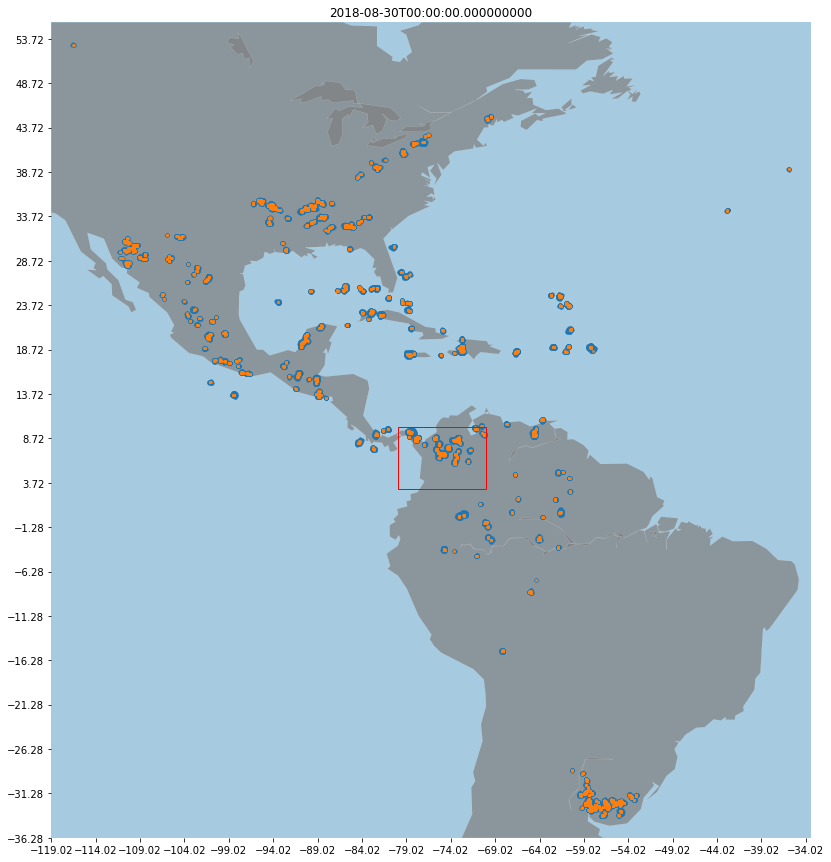

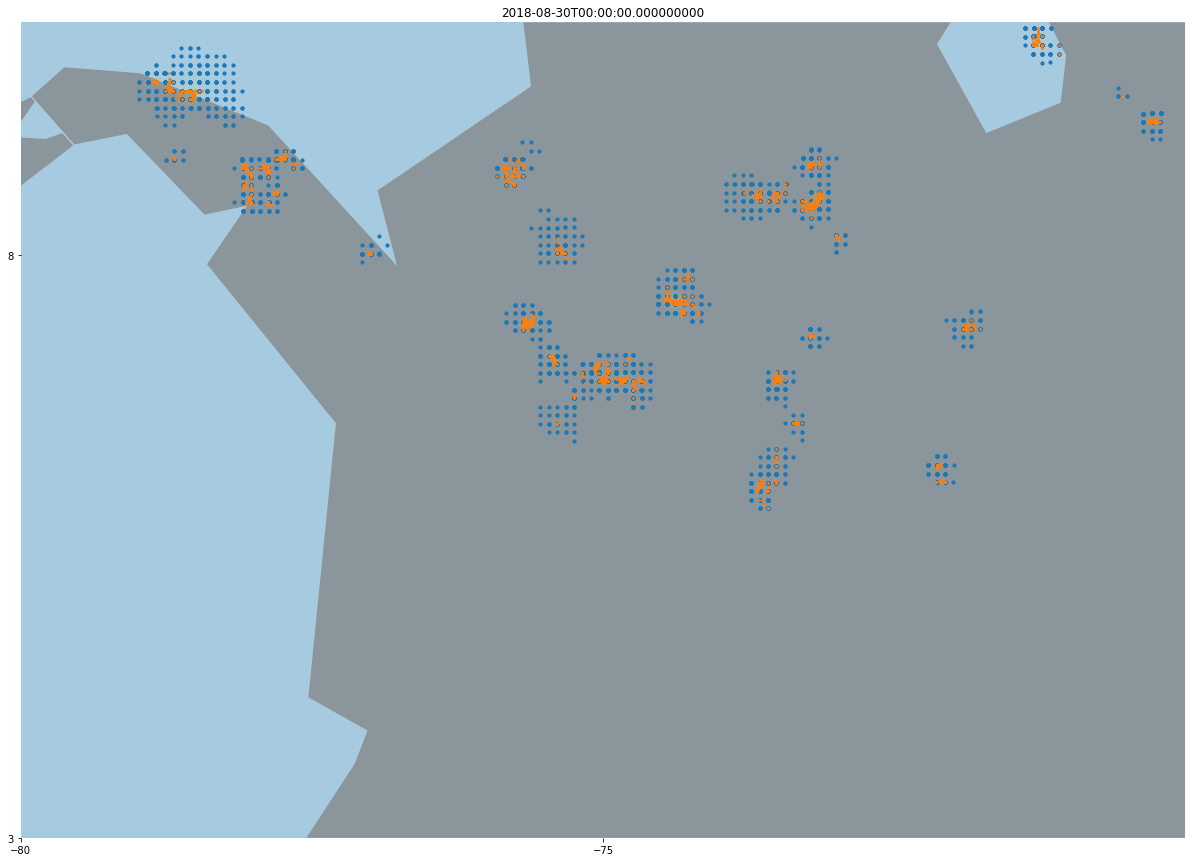

Wall time: 5.95 s


In [73]:
%%time
area = (-80,-70,10,3)
# Graph all events, flashes, groups, and events | can specify location of interest
MakeBigGraph(glm.dataset,2.5,area)

In [80]:
def convSeconds(x):
    if x[2] == '.':
        return x[:9]
    elif x[1] == '.':
        return x[:8]

def LoadWWLLNData(file,energy=False):
    if energy:
        df =  pd.read_csv(file,header=None,names=["Year","Month","Day","Hour","Minute","Seconds","Latitude","Longitude","Error","NumberStations","Energy",'Energy_std',"NumStationsEnergy"],low_memory=False)
        df['Seconds'] = df['Seconds'].astype('string').apply(convSeconds)
        df['Datetime'] = (df['Year'].astype('string')+'-'+df['Month'].astype('string')+'-'+df['Day'].astype('string')+'-'+df['Hour'].astype('string')+'-'+df['Minute'].astype('string')+'-'+df['Seconds'].astype('string')).apply(pd.to_datetime,format="%Y-%m-%d-%H-%M-%S.%f")
        df.drop(columns=['Year','Month','Day','Hour','Minute','Seconds'],inplace=True)
        return df
    else:
        return pd.read_csv(file,header=None,names=["Date","Time","Latitude","Longitude","Error","Number of Stations"],low_memory=False)

In [81]:
df = LoadWWLLNData('./WWLLN_Oct_2018/AE20200816.txt',energy=True)

In [78]:
area = (-76,-60,10,3)
start = pd.to_datetime('2020-08-16 00:00:00')
end = pd.to_datetime('2020-08-16 01:00:00')

small = df[(df['Datetime'] > start) & (df['Datetime'] < end)]
localize = small[(small['Longitude'] >= area[0]) & (small['Longitude'] <= area[1]) & (small['Latitude'] >= area[3]) & (small['Latitude'] <= area[2])]

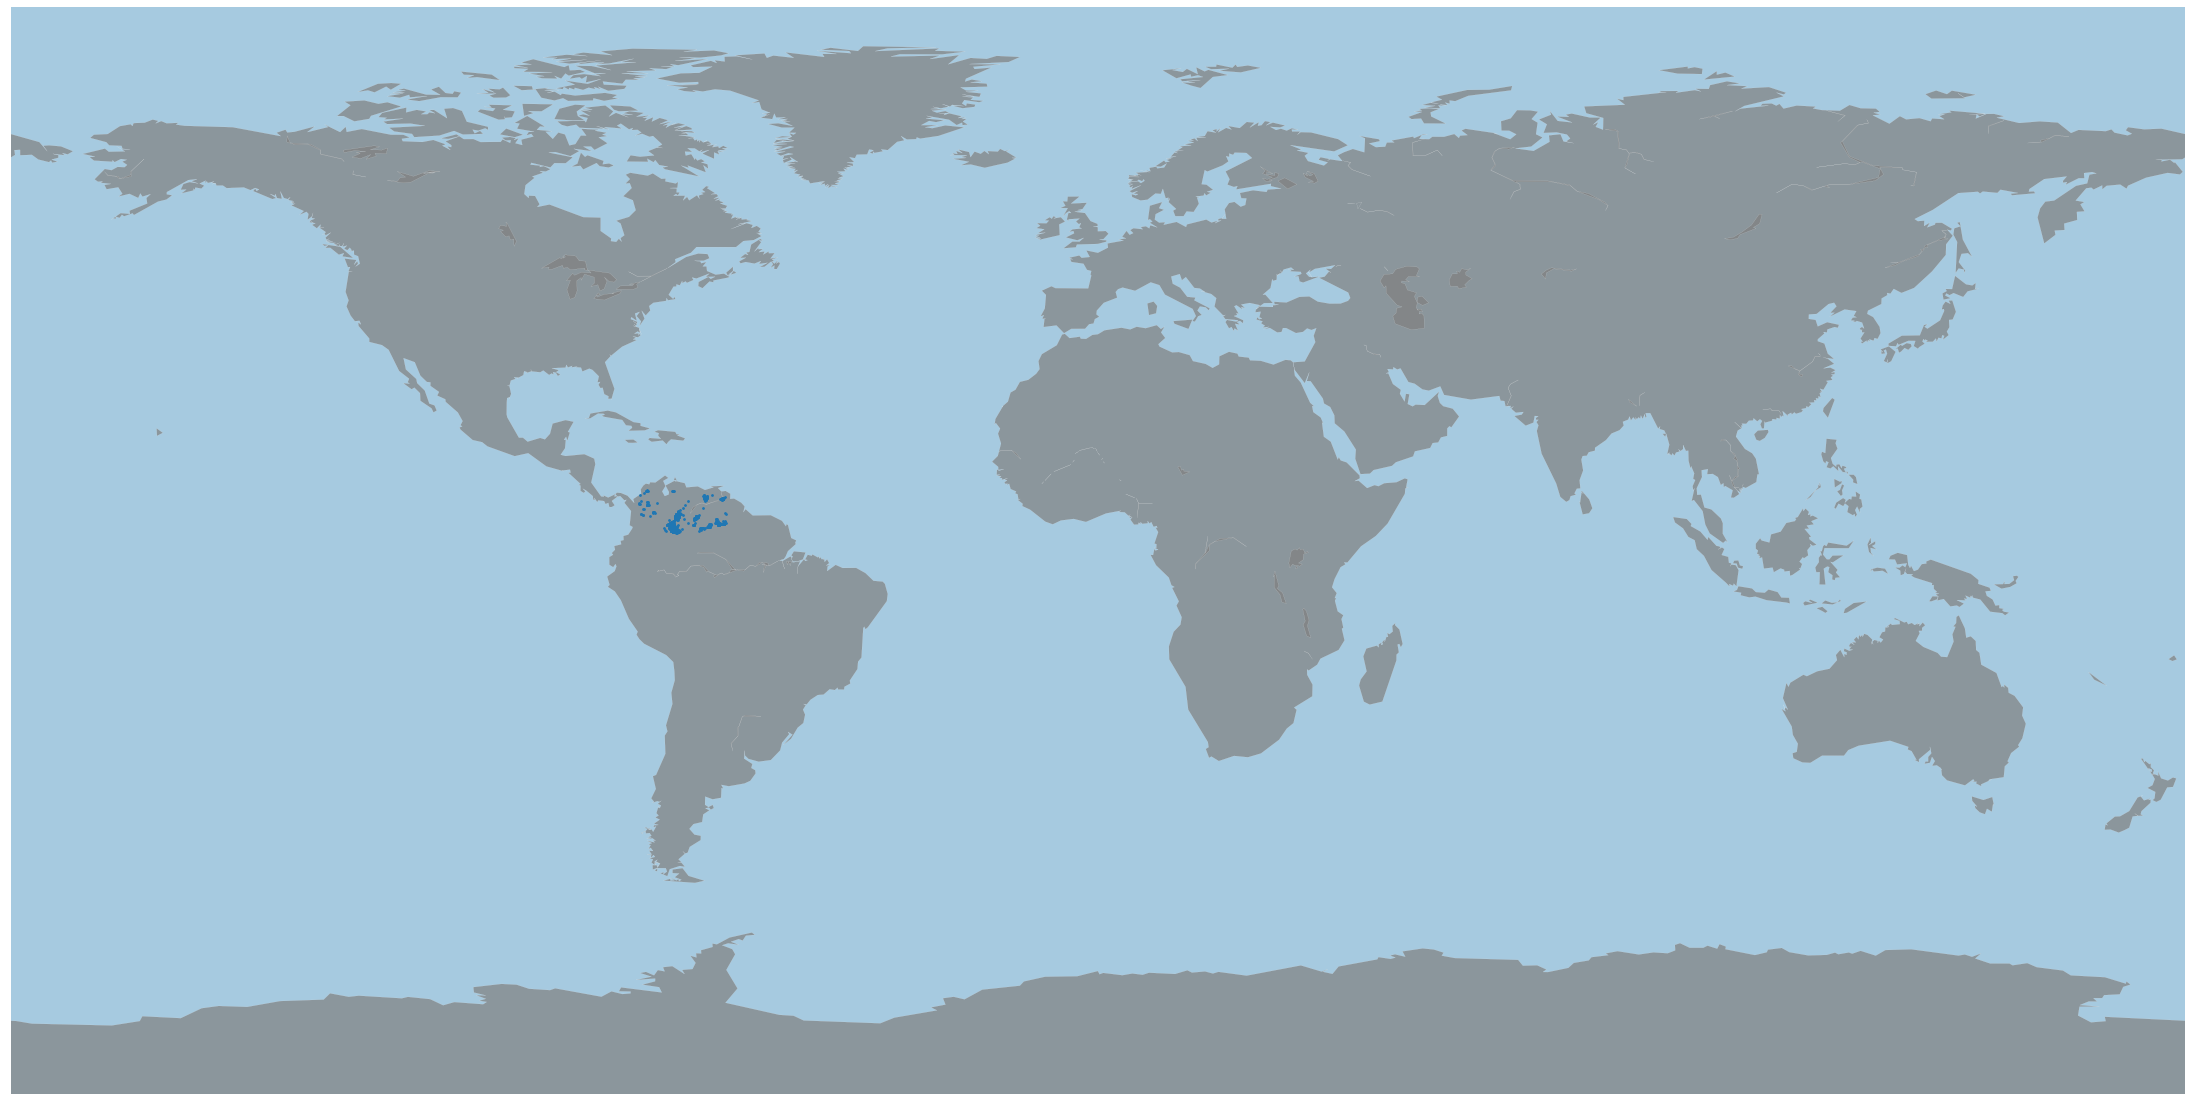

In [79]:
fig = plt.figure(figsize=(40,20))
m = BM.CreateMapBackground()
m.scatter(localize['Longitude'],localize['Latitude'],zorder=4,s=3)
plt.show()

In [5]:
# Error in file:./NCPython/NCPython/234/00/OR_GLM-L2-LCFA_G16_s20192340006400_e20192340007000_c20192340007029.nc
what = GLMDataset('./NCPython/NCPython/234/00/OR_GLM-L2-LCFA_G16_s20192340006400_e20192340007000_c20192340007029.nc')

In [8]:
what.dataset.dims['number_of_groups']

8871

In [11]:
what.dataset.group_energy

<xarray.DataArray 'group_energy' (number_of_groups: 8871)>
array([1.5259700e-06, 4.5779097e-06, 3.0519400e-06, ..., 3.0519400e-06,
       1.3733729e-05, 4.5779097e-06], dtype=float32)
Coordinates:
    group_id               (number_of_groups) uint32 636193754 ... 636203286
    group_time_offset      (number_of_groups) datetime64[ns] 2019-08-22T00:06...
    group_lat              (number_of_groups) float32 13.954406 ... 39.68829
    group_lon              (number_of_groups) float32 -87.896545 ... -104.86653
    group_parent_flash_id  (number_of_groups) uint16 64217 64217 ... 65017 65017
    product_time           datetime64[ns] 2019-08-22T00:06:40
    lightning_wavelength   float32 777.37
    group_time_threshold   float32 0.0
    flash_time_threshold   float32 3.33
    lat_field_of_view      float32 0.0
    lon_field_of_view      float32 -75.0
Dimensions without coordinates: number_of_groups
Attributes:
    units:    nJ

In [2]:
def combine_netcdf(files,output):
    combined = []
    for file in files:
        glm = xr.open_dataset(file)
        combined.append(glm.to_dataframe())
    big = pd.concat(combined)
    out = big.to_xarray()
    out.to_netcdf(output)

In [3]:
combine_netcdf(["./Data/Hurricane_Dorian/" + str(file) for file in os.listdir("./Data/Hurricane_Dorian/")],"Hurricane_Dorian.nc")

In [6]:
combine_netcdf(["./Data/Hurricane_Laura/" + str(file) for file in os.listdir('./Data/Hurricane_Laura/')],"Hurricane_Laura.nc")

In [4]:
data = xr.open_dataset('./Hurricane_Dorian.nc')

In [5]:
df = data.to_dataframe()
del data

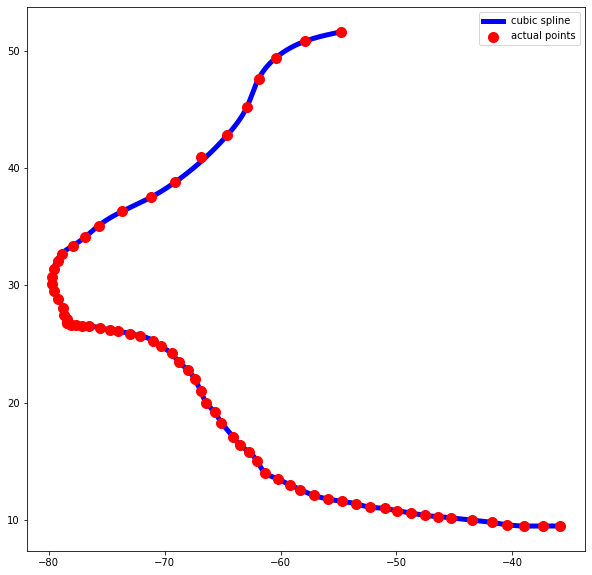

In [10]:
spline = scc.cubic_spline_trackfile('./Hurricane_Dorian/ATL_19_5_Dorian_Reduced_Trackfile.txt')
spline.to_csv('ATL_19_5_Dorian_Cubic_Spline_Trackfile.csv')

In [ ]:
laura_center = pd.read_csv('./Hurricane_Laura_2020/ATL_20_13_Laura_Reduced_Trackfile_Spline.csv')
laura_center['Date'] = laura_center['Date'].apply(pd.to_datetime)

dates = [pd.to_datetime(date) for date in laura_center['Date'].values]

In [2]:
laura_center = pd.read_csv('./Hurricane_Laura_2020/ATL_20_13_Laura_Reduced_Trackfile_Spline.csv')
laura_center['Date'] = laura_center['Date'].apply(pd.to_datetime)
laura = xr.open_dataset('./Hurricane_Laura.nc').to_dataframe()

dates = [pd.to_datetime(date) for date in laura_center['Date'].values]

In [4]:
laura

,group_energy,group_area,group_id,group_time_offset,group_lat,group_lon
number_of_groups,,,,,,
0,7.384298e-06,141.156723,2836535506,2020-08-15 23:59:59.659724713,-22.245550,-51.442871
1,1.185042e-06,70.502052,2836535507,2020-08-15 23:59:59.662013531,-22.206129,-51.451561
2,3.284790e-06,141.156723,2836535511,2020-08-15 23:59:59.665828228,-22.241041,-51.443794
3,1.838298e-05,211.811371,2836535513,2020-08-15 23:59:59.671931744,-22.240595,-51.439259
4,9.850660e-07,70.502052,2836535514,2020-08-15 23:59:59.673839093,-22.206142,-51.451508
...,...,...,...,...,...,...
6667,5.084574e-06,151.228455,1920082079,2020-08-27 23:59:59.348443984,16.699306,-96.282967
6668,3.584754e-06,151.228455,1920082097,2020-08-27 23:59:59.487682342,16.707689,-96.275009
6669,6.484406e-06,151.228455,1920082098,2020-08-27 23:59:59.489589691,16.697392,-96.284828


In [10]:
points = []
for index,date in enumerate(dates):
    subset = laura[(laura['group_time_offset'] >= date) & (laura['group_time_offset'] < date + datetime.timedelta(minutes=10))]
    center = laura_center[laura_center['Date'] == date]
    for point in subset.values:
        pt = point[-2:]
        dist = haversine.haversine(pt,(center['Long'],center['Lat']))
        if dist <= 500:
            points.append(point)
    print(date,end='\r')

KeyboardInterrupt: 

,Unnamed: 0,Date,Long,Lat
0,0,2020-08-16 18:00:00,-25.4,10.9


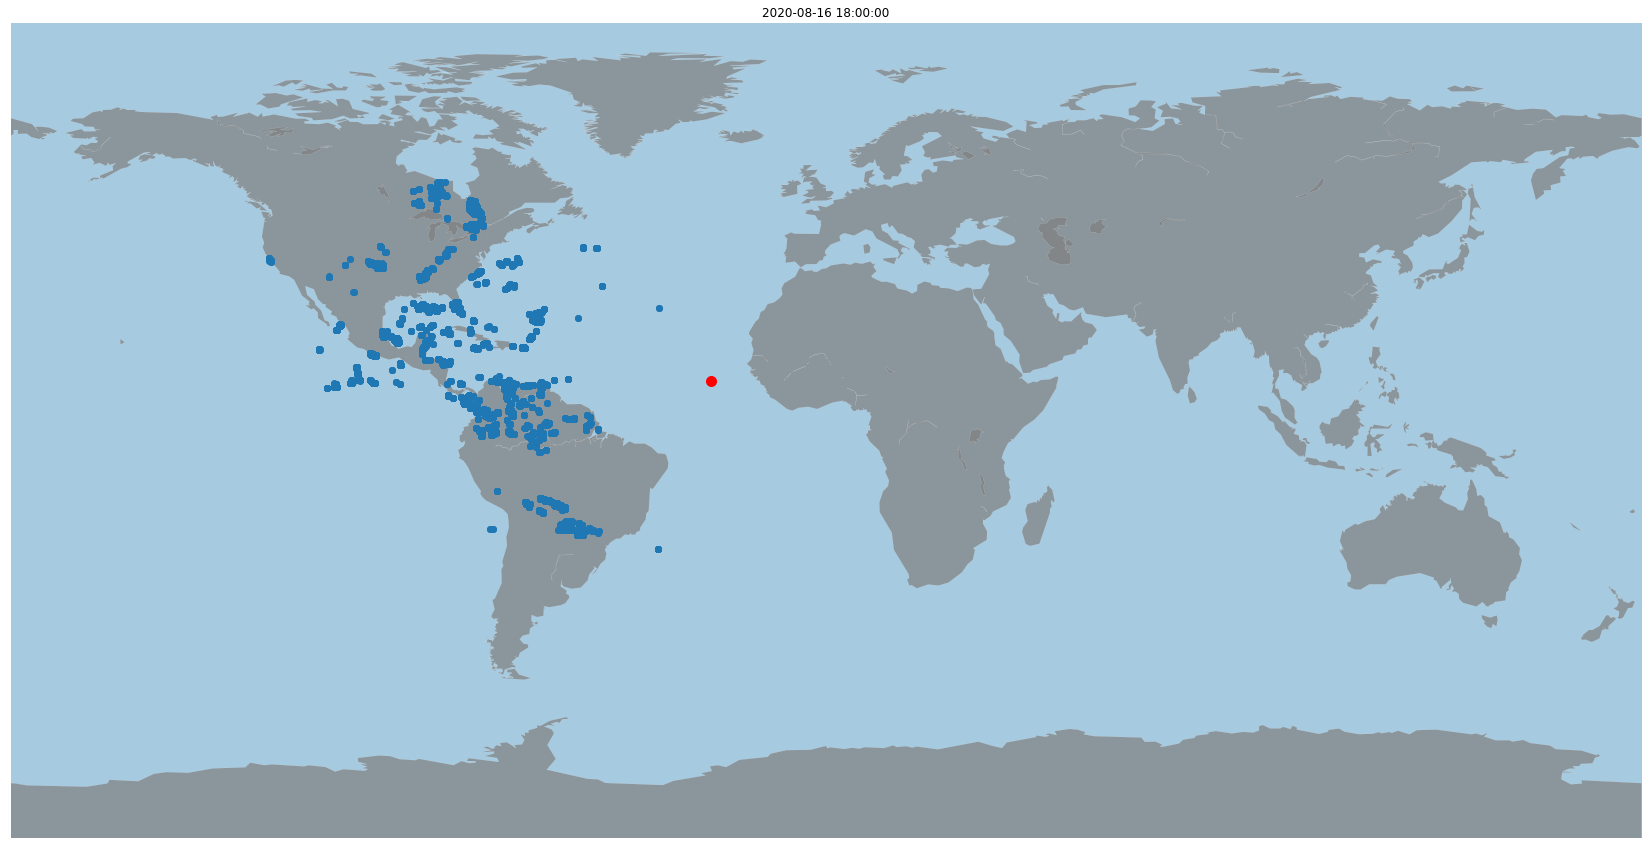

In [35]:
plt.ioff()
for index,date in enumerate(dates):
    fig = plt.figure(figsize=(30,15))
    figure = BetterMap.CreateMapBackground()
    subset = laura[(laura['group_time_offset'] >= date) & (laura['group_time_offset'] < date + datetime.timedelta(minutes=10))]
    plt.scatter(subset['group_lon'],subset['group_lat'],zorder=4)
    #plt.scatter(spline.iloc[index]['Long'],spline.iloc[index]['Lat'],c='r',zorder=4)
    center = laura_center[laura_center['Date'] == date]
    plt.scatter(center['Long'],center['Lat'],s=100,c='red',zorder=5)
    plt.title(date)
    #plt.savefig(f'./images/{index}',bbox_inches='tight')
    plt.close()
    break

KeyboardInterrupt: 

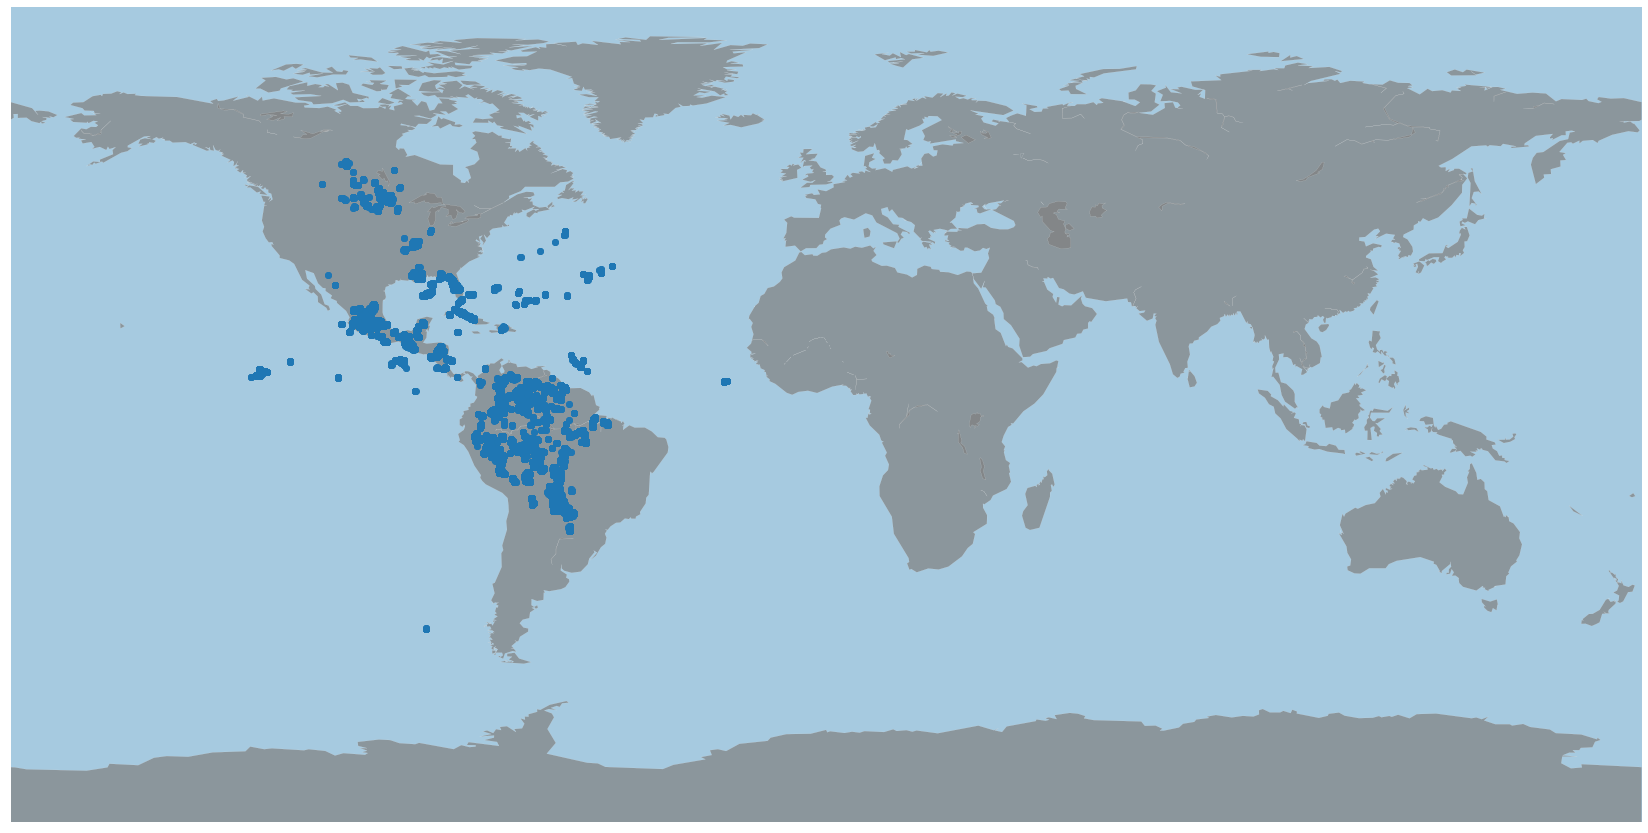

In [39]:
plt.ioff()
for index,date in enumerate(dates):
    fig = plt.figure(figsize=(30,15))
    figure = BetterMap.CreateMapBackground()
    subset = df[(df['group_time_offset'] >= date) & (df['group_time_offset'] < date + datetime.timedelta(minutes=10))]
    plt.scatter(subset['group_lon'],subset['group_lat'],zorder=4)
    plt.scatter(spline.iloc[index]['Long'],spline.iloc[index]['Lat'],c='r',zorder=4)
    plt.title(date)
    plt.savefig(f'./images/{index}',bbox_inches='tight')
    plt.close()